# Brain Tumor classification and detectionfrom MRI images using CNN based on ResUNet Architecture

Brain tumor is a serious disease occurring in human being. Medical treatment process mainly depends on tumor types and its location. The final decision of neurospecialists and radiologist for the tumor diagnosis mainly depend on evaluation of Magnetic Resonance Imaging (MRI) Images. The manual evaluation process is time consuming and needs domain expertise to avoid human errors. To overcome this issue Convolution Neural Network (CNN) deep learning algorithm based on ResUNet architecture is proposed for detecting the tumor and marking the area of their occurrence.There are several advantages to using these proposed architectures for segmentation task. First, a residual unit helps when training deep architectures. Second, feature accumulation with recurrent residual convolutional layers ensures better feature representation for segmentation tasks.The automatic brain tumor classification is very challenging task in large spatial and structural variability of surrounding region of brain tumor. The method proposed accuracy 96% on the test data.

This project is based on implementation using the Keras library with TensorFlow (Abadi et al., 2016) as the backend. They are open-source machine learning library capable of performing deep learning algorithm.

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
import skimage

from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [33]:
data = pd.read_csv('/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [34]:
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In the below step, the image files are read as a dataframe, the path name of the file will depend on where you store the data in your computer. Here '*' indicates selection of all the image file stored in kaggle_3m directory. The data is freely available at https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation. 

In [35]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


We can view the patient id and the path name of the file by using df.head()

In [36]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In the below section, we are storing the Brain MRI images and their corresponding mask in two seperate data frames i.e. df_imgs and df_masks.

You can calculate the base length of the path by using len() command, example is given below.

In [37]:
len("/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_")

89

In [38]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !---------------------------------------------------------------!!->.tif)
END_MASK_LEN = 9 # (lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

In [39]:
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))

In [40]:
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [41]:
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif


In this section, we are creating another data frame (brain_df) which consist of patient_id, image_path and mask_path. We are also creating a fucntion to read a value either 0 or 1, if the mask is present for the image then it returns 1 else it return 0.

In [42]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

We can also check the distribution of negative (with tumor) and positive (without tumor) for each file in the directory. 

In [43]:
patients_by_diagnosis = brain_df.groupby(['patient_id', 'mask'])['mask'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Negative", "Positive"]

patients_by_diagnosis.head()

Negative  Positive
patient_id                               
TCGA_CS_4941_19960909      11.0      12.0
TCGA_CS_4942_19970222       8.0      12.0
TCGA_CS_4943_20000902       8.0      12.0
TCGA_CS_4944_20010208      17.0       3.0
TCGA_CS_5393_19990606      12.0       8.0

This section shows the distribution of data grouped by patient and diagnosis.

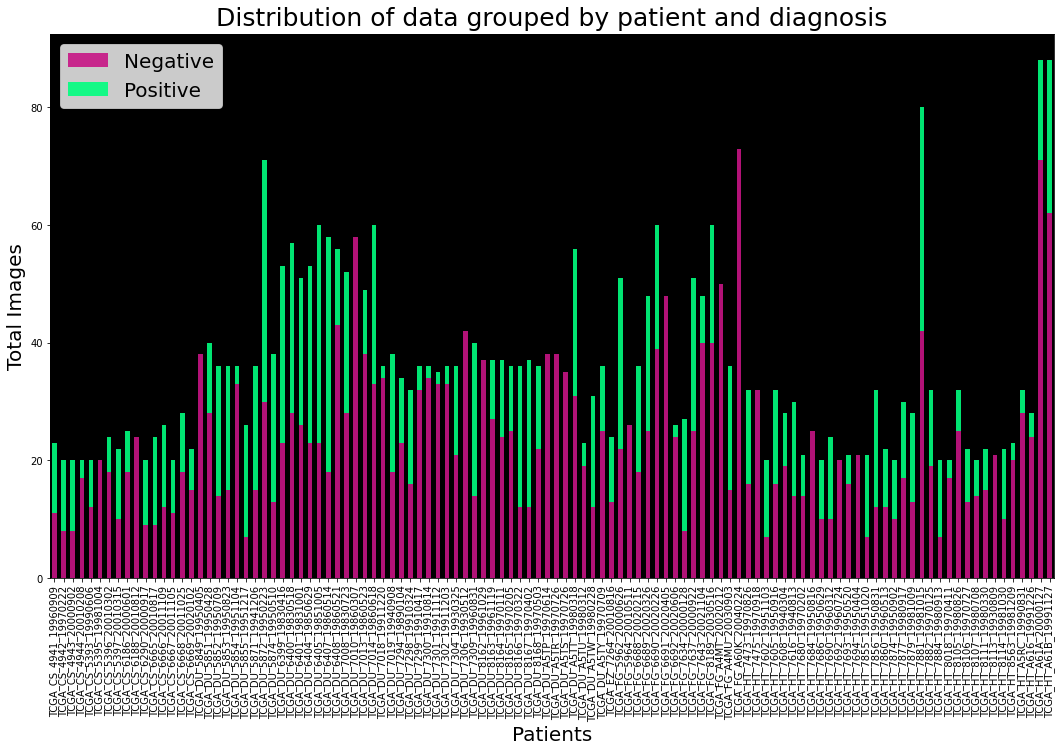

In [44]:
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)
ax.set_facecolor('xkcd:black')

# 2. DATA VISUALIZATION

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


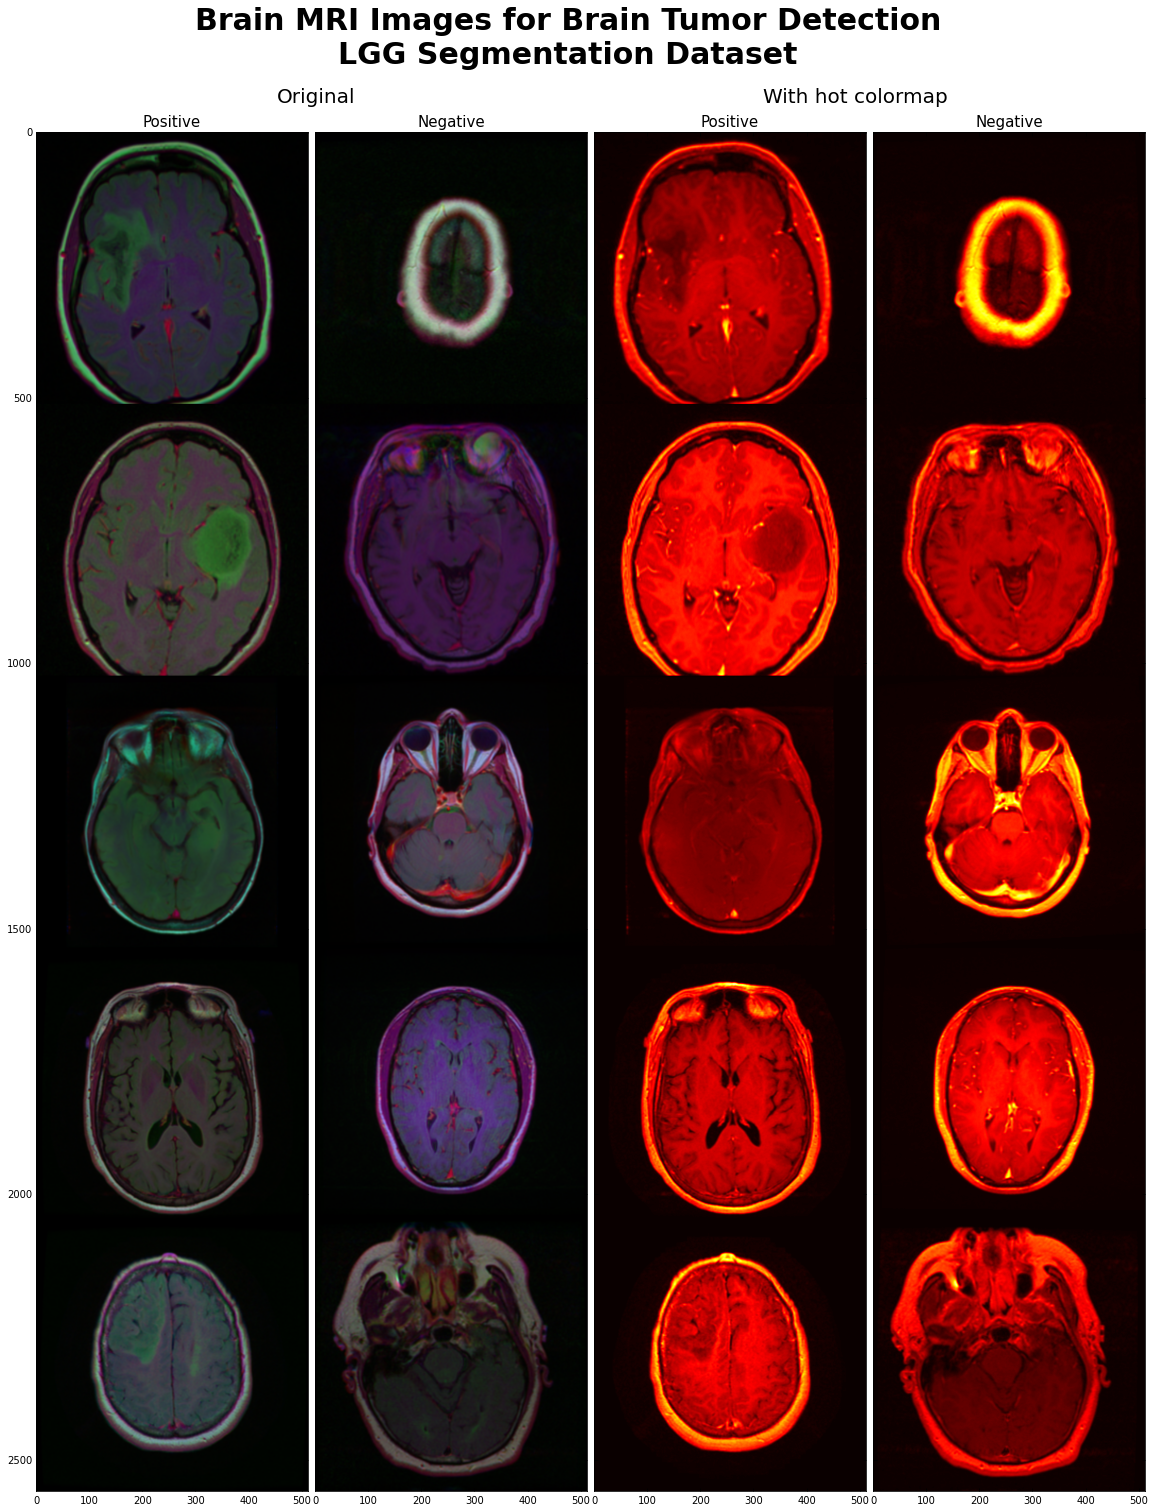

In [45]:
# Data
from mpl_toolkits.axes_grid import ImageGrid

IMG_SIZE = 512
sample_yes_df = brain_df[brain_df["mask"] == 1].sample(5).image_path.values
sample_no_df = brain_df[brain_df["mask"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

In [46]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [47]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

 There are total of 2556 images withno tumor and 1373 images with tumor.

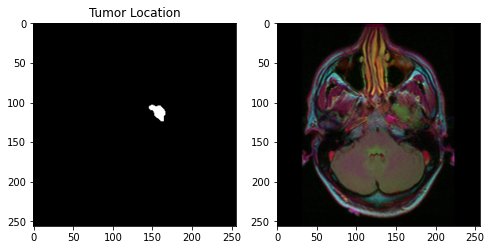

In [48]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));
plt.savefig('books_read.png')

In [49]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

In [50]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy 
#import skimage.external.tifffile as skimg
from skimage.io import imread,imshow
from skimage.color import rgb2gray
from skimage.transform import resize

In [52]:
im  = imread('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14.tif')

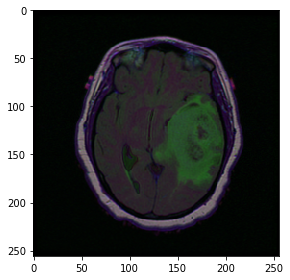

In [53]:
imshow(im)

In [54]:
grayim = rgb2gray(im)

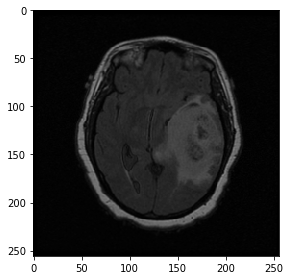

In [55]:
imshow(grayim)

# Feature Extraction process
It is the process of collecting higher-level information of an image such as shape, texture, color, and contrast. In fact, texture analysis is an important parameter of human visual perception and machine learning system. It is used effectively to improve the accuracy of diagnosis system by selecting prominent features. one of the most widely used image analysis applications of Gray Level Cooccurrence Matrix (GLCM) and texture feature. 

In [56]:
from skimage.exposure import histogram
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy
from skimage import io, color, img_as_ubyte

hist, hist_centers = histogram(grayim)


In [57]:
#Gray level Cooccurance Matry 
grayImg = img_as_ubyte(grayim)
distances = [1, 2, 3]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
properties = ['energy', 'homogeneity']

glcm = greycomatrix(grayImg, 
                    distances=distances, 
                    angles=angles,
                    symmetric=True,
                    normed=True)

feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:35: skimage_deprecation:

Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.



In [58]:
entropy(grayImg)

3.4778980772349875

In [59]:
np.set_printoptions(precision=4)
print(feats)

[0.1539 0.1426 0.148  0.1426 0.1405 0.1426 0.1404 0.1426 0.138  0.1374
 0.1382 0.1372 0.4809 0.4137 0.4691 0.4149 0.3901 0.4137 0.3919 0.4149
 0.3691 0.3624 0.3714 0.3621]


/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.



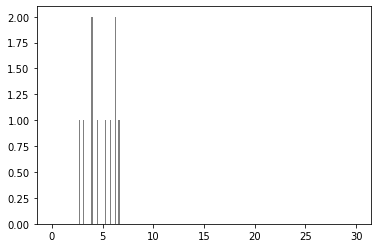

In [60]:
dis = (greycoprops(glcm, 'dissimilarity'))
plt.hist(dis.ravel(), bins=256, range=(0, 30),facecolor='0.5');plt.show()

In [61]:
# GLCM Texture Features
ds = []
cr = []
cn = []
am = []
en = []
ho = []

glcm = greycomatrix(grayImg, [5], [0], symmetric=True, normed=True)
ds.append(greycoprops(glcm, 'dissimilarity')[0,0])
cr.append(greycoprops(glcm, 'correlation')[0,0])
cn.append(greycoprops(glcm, 'contrast')[0,0])
am.append(greycoprops(glcm, 'ASM')[0,0])
en.append(greycoprops(glcm, 'energy')[0,0])
ho.append(greycoprops(glcm, 'homogeneity')[0,0])
    
    
print('dissimilarity',ds)
print('correlation',cr)
print('contrast',cn)
print('ASM',am)
print('energy',en)
print('homogeneity',ho)

dissimilarity [8.977122758964144]
correlation [0.6865382731981159]
contrast [427.2979643924303]
ASM [0.018254842158887178]
energy [0.13511048130654846]
homogeneity [0.3501554222288041]


/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:35: skimage_deprecation:

Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation:

Function ``greycoprops`` is deprecated and will b

Visualize the images (MRI and Mask) in the dataset separately

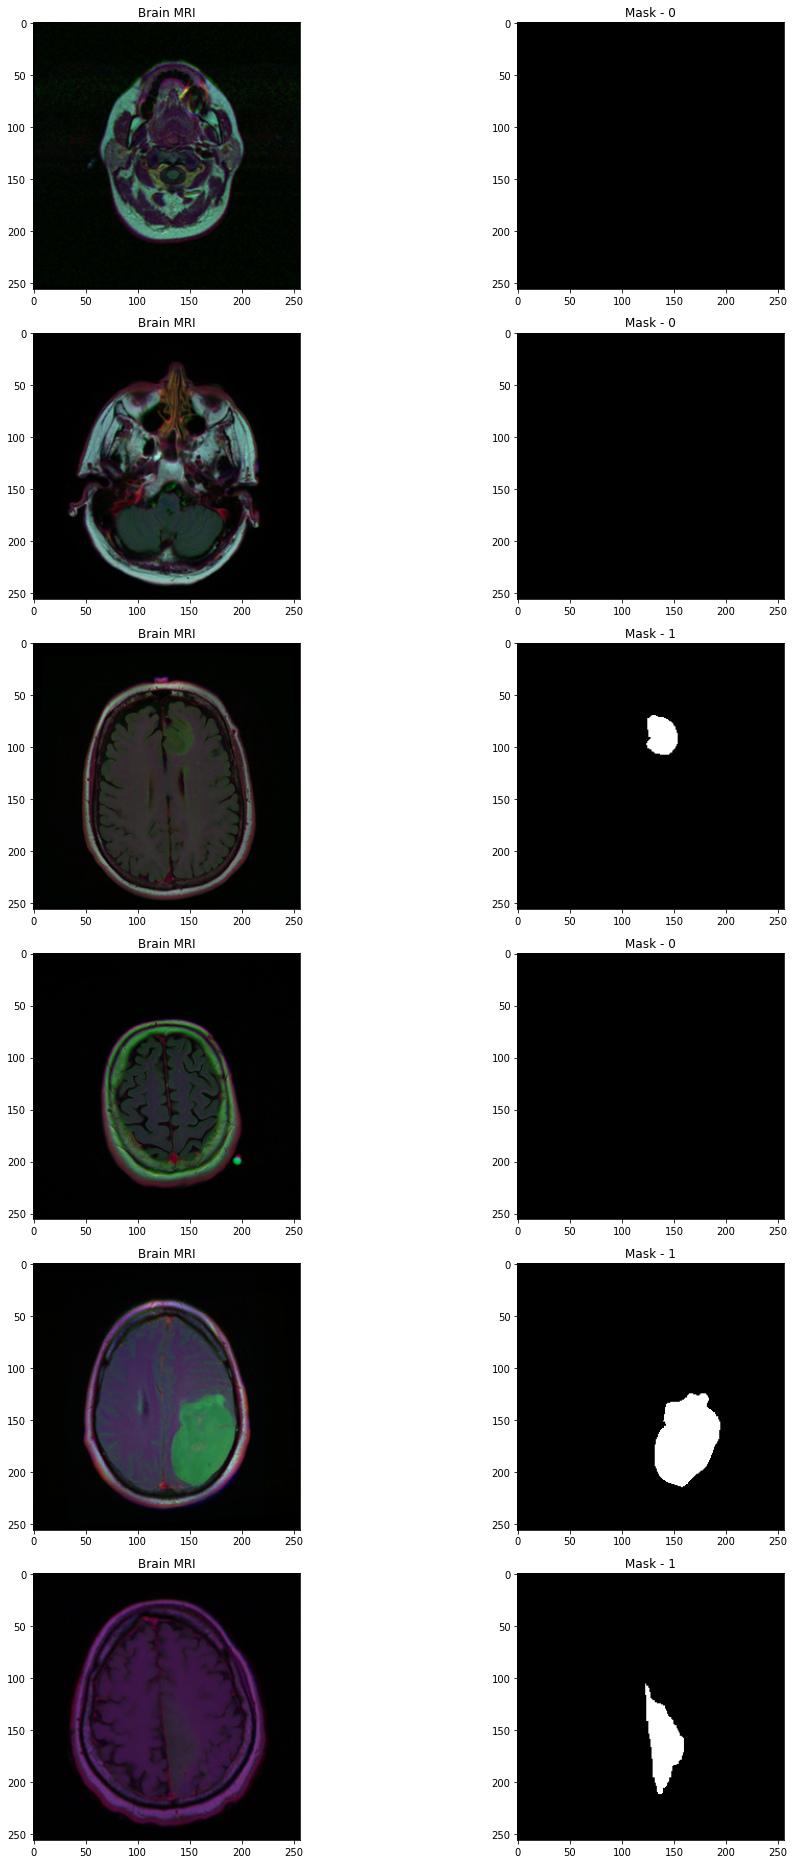

In [62]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

Visualize the images (MRI and Mask) in the dataset separately and the use convolution method to add Brain MRI. and mask to get MRI image with mask

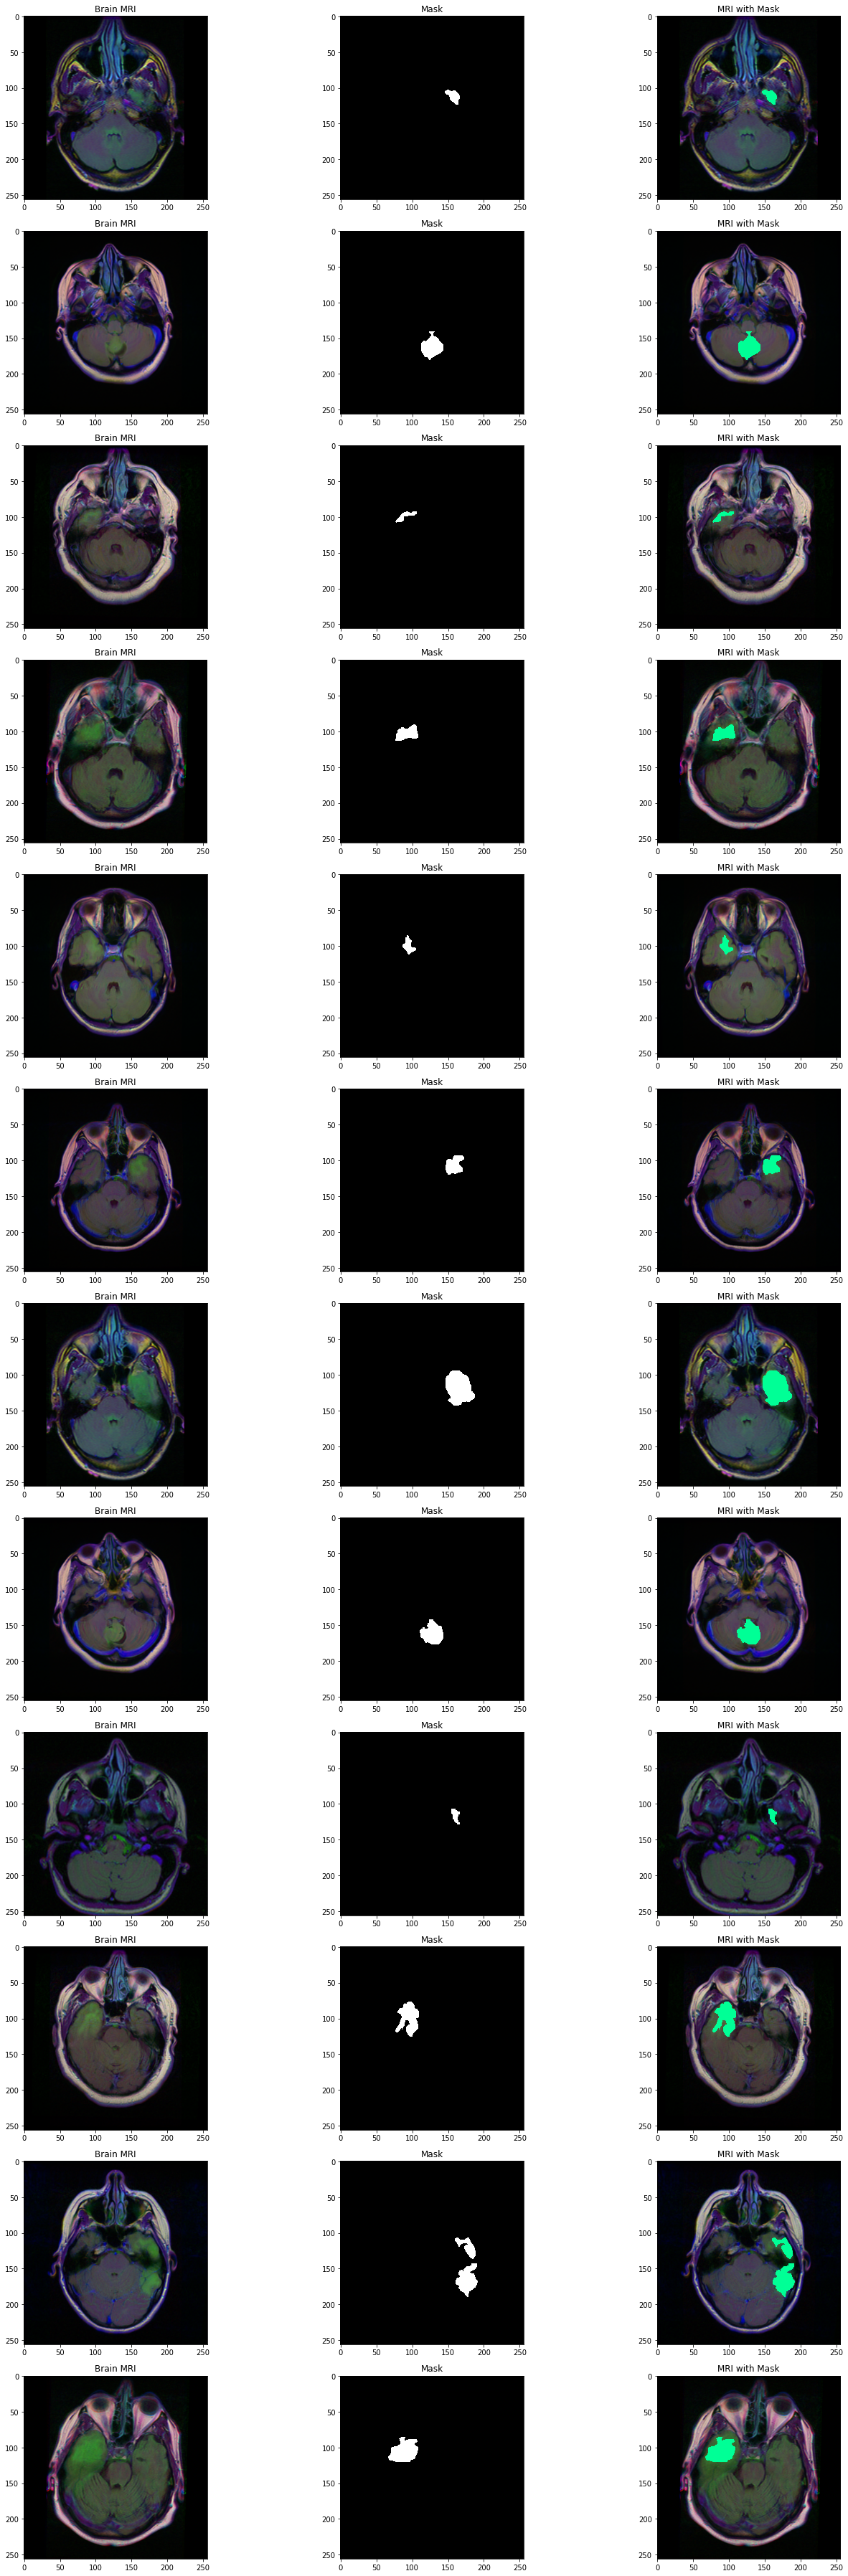

In [63]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

Here, we will remove the column 'patient_id' 

In [64]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


# CRETING TEST, TRAIN & VAL SET

In [65]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)


# Image data augmentation
Image data augmentation generate new training samples from the original datasetby adding random alteration in the arrangement of the images, but at the same timeensuring that the class labels of the data are not differed. 

When applying data augmentation, our goal is to increase the generalizability of the model. Data augmentation is not applied in test dataset, therefore, it increases accuracy. Data augmentation is implemented by using ImageDataGenerator in Keras (Gulli and Pal, 2017).An input batch of image is presented to the ImageDataGener-ator. This transforms each images in the batch by series of random transformation.Lastly, the randomly transformed batch is then returned to the calling function.Here, the ImageDataGenerator is not returning both the original data and the trans-formed data, it only returns the randomly transformed data.

In [66]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


##  TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In this project, instead of building a new network, the Resnet50 model is used asthe base to train the model.  The residual network is a deep convolution neuralnetwork model that was introduced by Microsoft in 2015 (Szegedy et al., 2015). Thereason for using Resnet50 model at the base is that it is desirable to benefit from thecollection of previously trained network, and also that Resnet50 model has achievedsuccessful results in biomedical data. Furthermore, in residual network rather thanlearning features from the layers, the model learns from the residual that are resultof the subtraction of features learned from the input from the layers (H. A. Khanet al., 2020). 

In [67]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

2023-01-22 12:16:27.893070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:16:27.984585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:16:27.985357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 12:16:27.986954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [68]:
# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False

The layers present in the residual network are -Input layer, Paddinglayer, Convolution layer, Batch normalization, Activation (ReLu), and Max pooling.Apart from these additional layers are added to the model. These additional layersare - Average Pooling, Flatten, Dense, Dropout to increase the total number ofparameters, consequently, increasing the number of trainable parameters.

In [69]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Early Stopping is used to stop the training when a monitored metric has stopped improving. Learn more about early stopping at https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping



In [70]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [91]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 17, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/5
187/187 [==============================] - 25s 133ms/step - loss: 0.1196 - accuracy: 0.9559 - val_loss: 0.3466 - val_accuracy: 0.8531

Epoch 00001: val_loss did not improve from 0.24433
Epoch 2/5
187/187 [==============================] - 25s 134ms/step - loss: 0.1557 - accuracy: 0.9415 - val_loss: 0.2647 - val_accuracy: 0.8906

Epoch 00002: val_loss did not improve from 0.24433
Epoch 3/5
187/187 [==============================] - 25s 133ms/step - loss: 0.0987 - accuracy: 0.9629 - val_loss: 0.2608 - val_accuracy: 0.8875

Epoch 00003: val_loss did not improve from 0.24433
Epoch 4/5
187/187 [==============================] - 25s 132ms/step - loss: 0.0976 - accuracy: 0.9645 - val_loss: 0.4746 - val_accuracy: 0.8625

Epoch 00004: val_loss did not improve from 0.24433
Epoch 5/5
187/187 [==============================] - 25s 132ms/step - loss: 0.1034 - accuracy: 0.9635 - val_loss: 0.1411 - val_accuracy: 0.9656

Epoch 00005: val_loss improved from 0.24433 to 0.14109, saving model to

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [92]:
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [93]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# CLASSIFIACTION MODEL EVALUATION

Here as a performance metrics categorical crossentropy is used for evaluation of classification model. check out this amazing blog on cross entropy written by Jason Brownlee https://machinelearningmastery.com/cross-entropy-for-machine-learning/

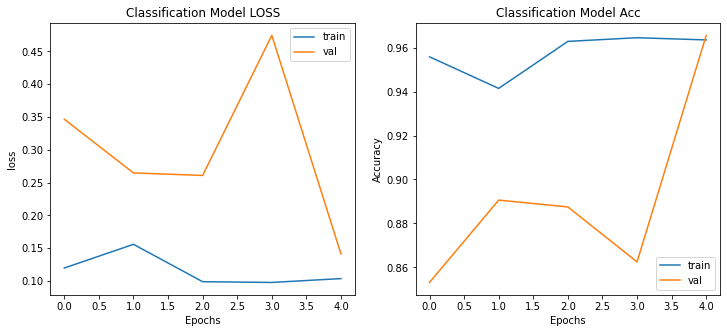

In [94]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [95]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 52ms/step - loss: 0.2330 - accuracy: 0.9339
Test accuracy : 93.38983297348022 %


Accuracyis one metric for evaluating the classification models. The accuracy ofthe model can be easily be calculated by the confusion matrix. 

0.9338983050847458
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       392
           1       0.91      0.89      0.90       198

    accuracy                           0.93       590
   macro avg       0.93      0.92      0.93       590
weighted avg       0.93      0.93      0.93       590



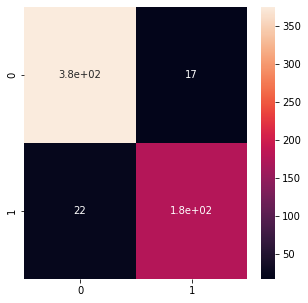

In [96]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

# BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [97]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [98]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [99]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

# ResUNet

The typical use of convolution networks is a classification tasks, where the output to an image is single class label. However, in many biomedical image processing, the desired output should include localization, i.e., a class label is supposed to be assigned to each pixel . The segmentation is a process that partitions an image into regions, which allows to separate objects and texture in images. 
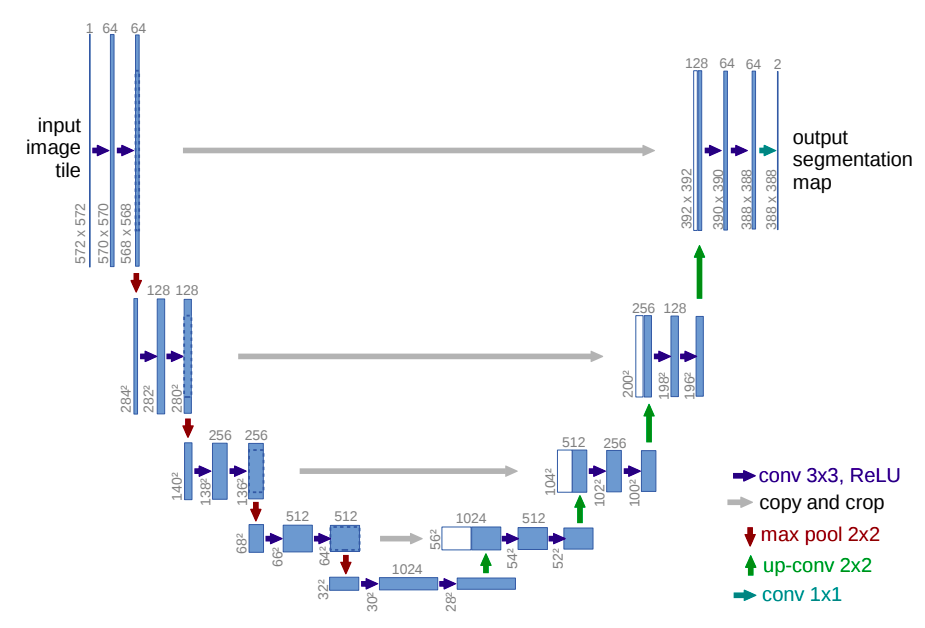


ResUNet consists of two part - contraction path and expansion path. The contraction path consist of several contraction blocks, each block takes an input that passes through res-blocks followed by 2x2 max pooling. Feature maps after each block doubles, which helps the model learn complex feature effectively. The most significant aspect of this architecture lies in expansion or decoder section. Each block takes in the up-sampled input from the previous layer and concatenates with the corresponding output features from the res-blocks in the contraction path. This feature ensures that the features learned while contracting are used while reconstructing the image. In the last layer of expansion path, the output from the res.block is passed through the 1x1 convolution layer to produce the desired output with the same size as the input.



In [100]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [101]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

# Train and evaluate model

In order for model to learn the objective faster and accurately, it is important to ensure that the mathematical representation of objectives are able to cover the edge cases. In addition, class imbalance dataset is a frequent problem experienced when performing segmentation. Therefore, to deal with the class imbalance problem the loss function are used for updating the weight vector by using labelled output and calculated output of the model. In the medical community, the Dice score coefficient (DSC) is widely used to asses segmentation. The Dice Coefficient is well known for being the go to evaluation metric for image segmentation, but it can also serve as a loss function. Dice coefficient only consider the segmentation class and not the background class. Therefore, a novel approach proposed by  (Abraham and N. M. Khan, 2019), the focal Tversky loss function (FTL) is used to evaluate the model.

"We need a custom loss function to train this ResUNet. So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py "

In [102]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [104]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [105]:
h = seg_model.fit(train_data, 
                  epochs = 20, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/20
72/72 [==============================] - 12s 135ms/step - loss: 0.9060 - tversky: 0.1232 - val_loss: 0.8954 - val_tversky: 0.1370

Epoch 00001: val_loss improved from inf to 0.89538, saving model to ResUNet-segModel-weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/20
72/72 [==============================] - 8s 111ms/step - loss: 0.8346 - tversky: 0.2137 - val_loss: 0.7728 - val_tversky: 0.2905

Epoch 00002: val_loss improved from 0.89538 to 0.77283, saving model to ResUNet-segModel-weights.hdf5
Epoch 3/20
72/72 [==============================] - 8s 111ms/step - loss: 0.5674 - tversky: 0.5252 - val_loss: 0.7279 - val_tversky: 0.3449

Epoch 00003: val_loss improved from 0.77283 to 0.72794, saving model to ResUNet-segModel-weights.hdf5
Epoch 4/20
72/72 [==============================] - 8s 110ms/step - loss: 0.3839 - tversky: 0.7181 - val_loss: 0.6457 - val_tversky: 0.4417

Epoch 00004: val_loss improved from 0.72794 to 0.64573, saving model to ResUNet-segModel-weights.hdf5
Epoch 5/20
72/72 [==============================] - 8s 116ms/step - loss: 0.3311 - tversky: 0.7696 - val_loss: 0.6830 - val_tversky: 0.3970

Epoch 00005: val_loss did not improve from 0.64573
Epoch 6/20
72/72 [==============================] - 8s 112ms/step - loss: 0.295

In [106]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

# SEGMENTATION MODEL EVALUATION

In [107]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

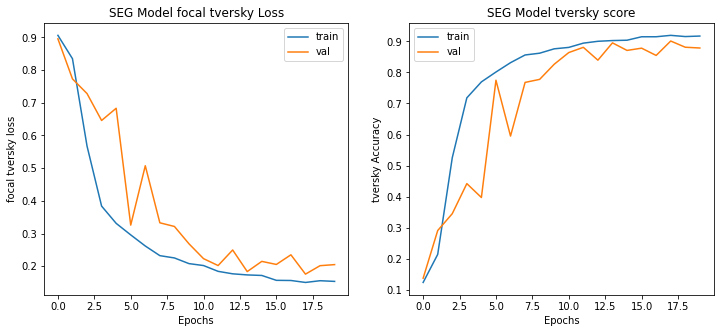

In [108]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [109]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 114ms/step - loss: 0.1937 - tversky: 0.8873
Segmentation tversky is 88.73%


# Prediction 

Finally, prediction function takes data frame containing ImageID as Input and perform 2type of prediction on the image. Initially, image is passed through the classificationnetwork which predicts whether the image has tumor or not. Next, if the model issure that the image has no tumor, then the image is labeled as no-tumor. Again,if the model is not sure, it passes the image to the segmentation network, it againchecks if the image has tumor or not, if it has tumor, then the type and location ofdefect is found.


In [110]:
def prediction(test, model, model_seg):
  
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [111]:
# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
..                                                 ...   
585  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
586  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
587  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
588  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
589  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                        predicted_mask  has_mask  
0    [[[[2.2382e-05], [2.1052e-05], [2.2362e-05], [...         1  
1                                           No mask :)         0  
2                                           No mask :)         0  
3    [[[[1.4904e-05], [1.746e-05], [1.6946e-05], [1...         1  
4    [[[[1.6372e-05], [1.8289e-05], [1.6568e-05], [...         1  
..                                                 ...       ...  
585                                         No mask :)         0  
586                                         No mask :)         0  
587                                         No mask :)         0  
588  [[[[1.6829e-05], [1.7716e-05], [1.5832e-05], [...         1  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [112]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   

                                      predicted_mask  has_mask  
0  [[[[2.2382e-05], [2.1052e-05], [2.2362e-05], [...         1  
1                                         No mask :)         0  
2                                         No mask :)         0  
3  [[[[1.4904e-05], [1.746e-05], [1.6946e-05], [1...         1  
4  [[[[1.6372e-05], [1.8289e-05], [1.6568e-05], [...         1  
5  [[[[1.3381e-05], [1.7983e-05], [1.722e-05], [1...         1  
6                                         No mask :)         0  
7  [[[[1.608e-05], [4.2869e-06], [1.9542e-06], [1...         1  
8                                         No mask :)         0  
9  [[[[1.3551e-05], [1.8049e-05], [1.721e-05], [1...         1

# Visualising results

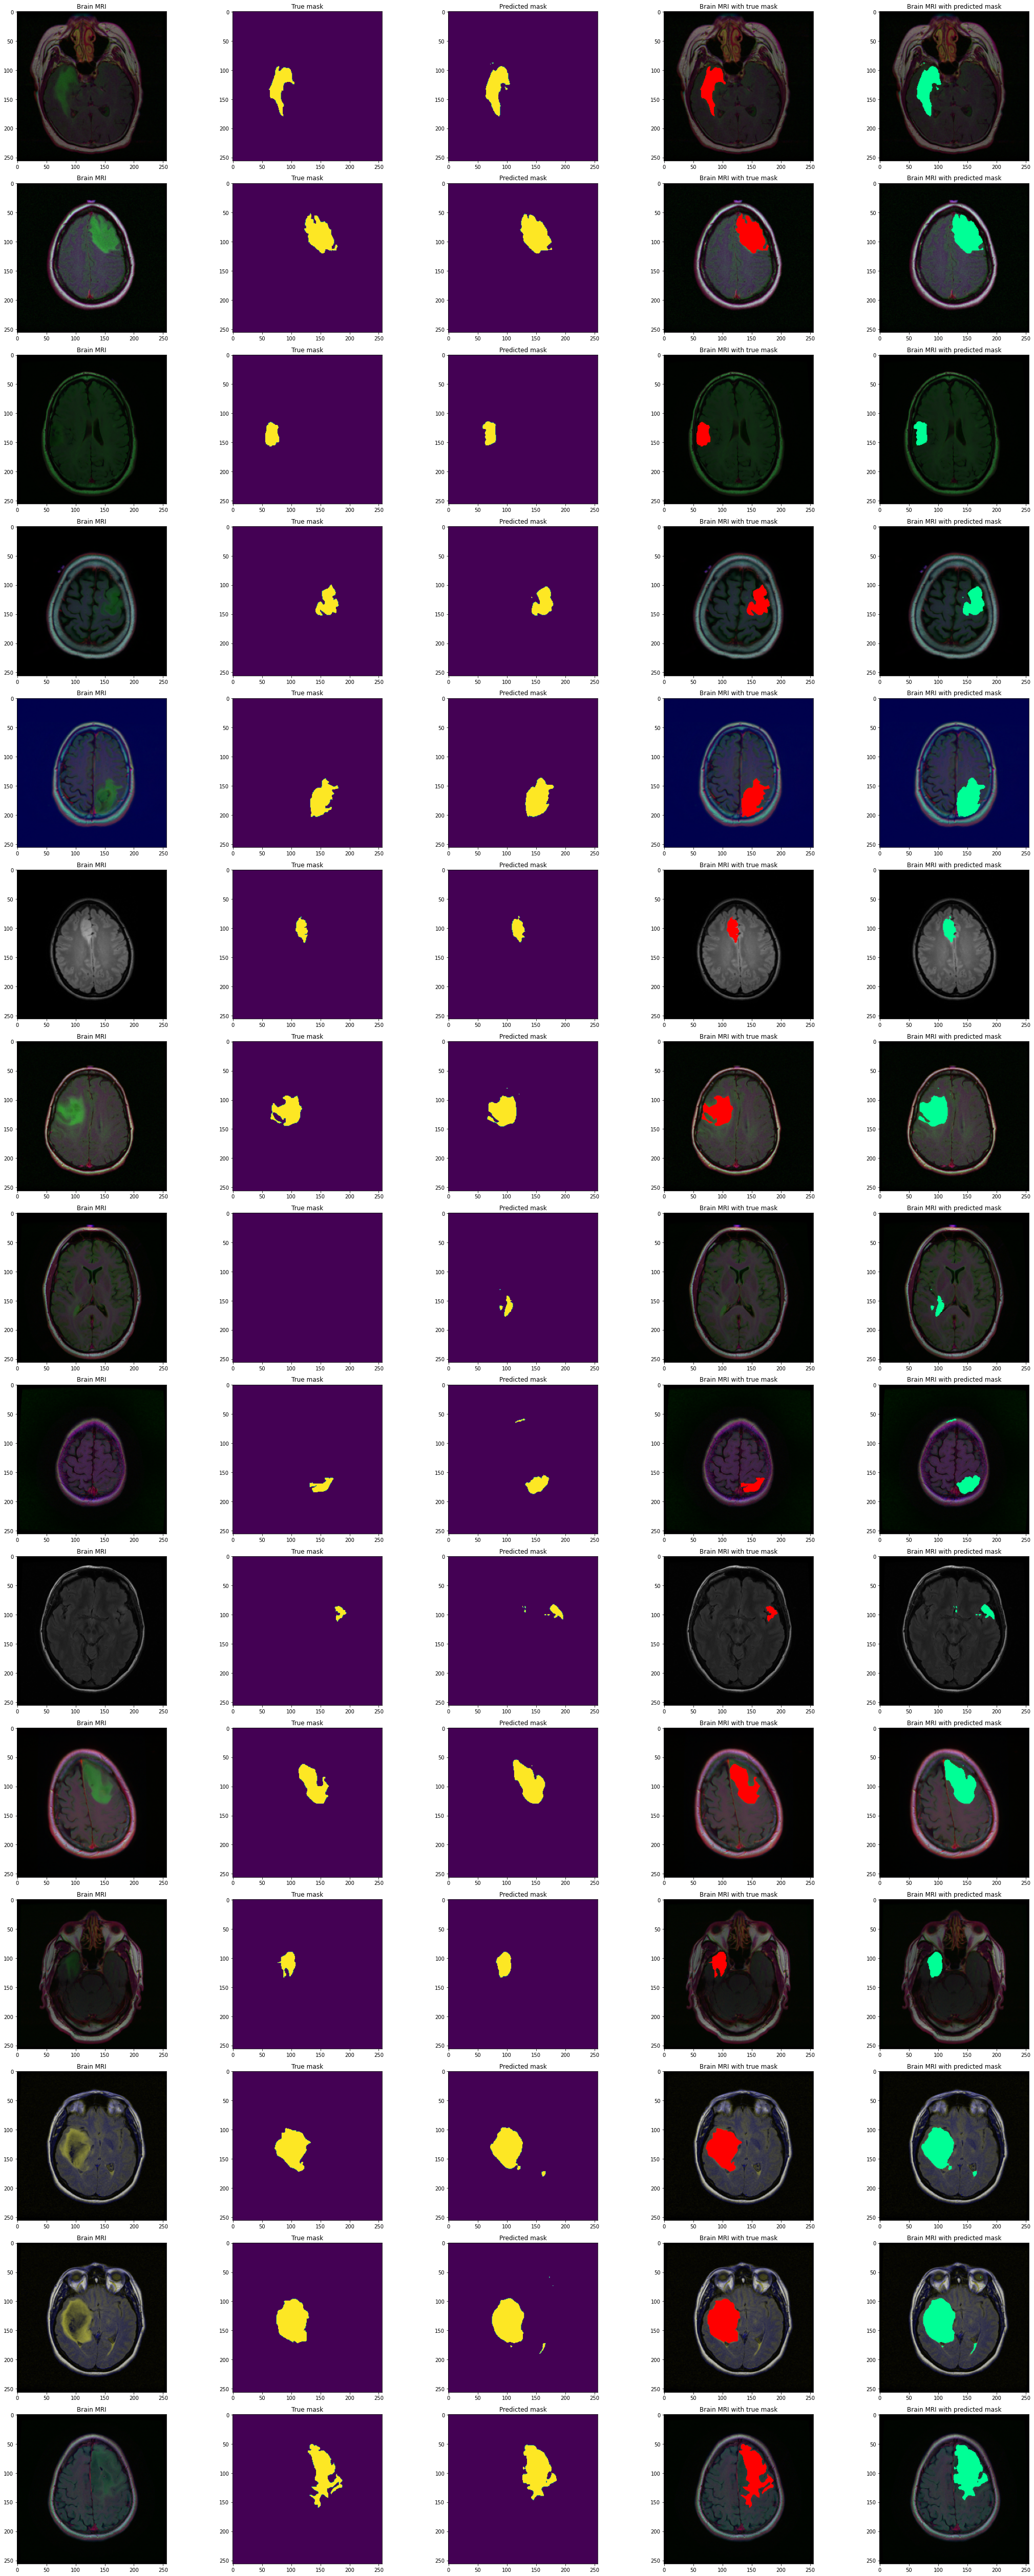

In [113]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('True mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('Predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with true mask')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('Brain MRI with predicted mask')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()

In [ ]:
with open('ResUNet-seg-model.json', 'r') as json_model:
  json_saved_model = json_model.read()

model_seg1 = tf.keras.models.model_from_json(json_saved_model)
model_seg1.load_weights('ResUNet-segModel-weights.hdf5')
model_seg1.compile(optimizer=optimizers.Adam(lr=0.05, epsilon=0.1), loss=focal_tversky, metrics=[tversky])


In [ ]:
image_id, mask, has_mask = prediction(test, model, model_seg1)
df2 = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df2 = test.merge(df2, on='image_path')
df2.has_mask = df2.has_mask.astype(str) # as 'mask' column was in df test of type str
df2.head(3)

In [ ]:
# False negative examples
df_FN = df2[df2['has_mask'] < df2['mask']]
df_FN.reset_index(inplace=True)
df_FN

### change the size of rows/cols if you have another df with FN/FP
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
  img = io.imread(df_FN.image_path[i])
  axes[i][0].imshow(img)
  axes[i][0].set_title('Brain MRI')

  mask = io.imread(df_FN.mask_path[i])
  axes[i][1].imshow(mask, cmap='gray')
  axes[i][1].set_title('True Mask')

  img[mask == 255] = (255, 0, 0)
  axes[i][2].imshow(img)
  axes[i][2].set_title('Brain tumor wasn\'t detected')

  axes[i][0].axis('off')
  axes[i][1].axis('off')
  axes[i][2].axis('off')
plt.tight_layout()
# as you can see these brain tumors are really so small